In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


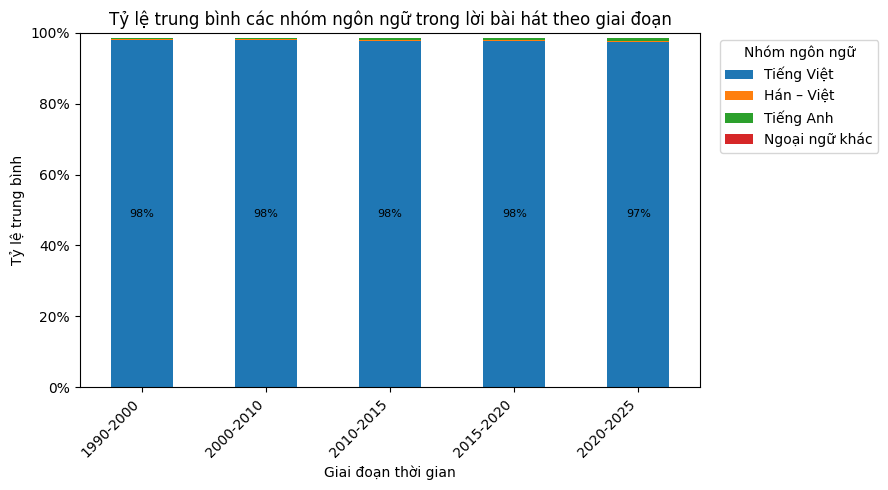

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# =========================
# 1. LOAD DATA
# =========================
PATH = "/content/drive/MyDrive/TDTU/Labeling/Calculate_Analysis/final_dataset_with_period.csv"
df = pd.read_csv(PATH, low_memory=False)

df = df[df["period"].notna()].copy()

# =========================
# 2. QUY ĐỔI CÁC TỶ LỆ ĐÃ CÓ
# =========================
base_pct_cols = {
    "pct_vietnamese": "Tiếng Việt",
    "pct_hanviet": "Hán – Việt",
    "pct_english": "Tiếng Anh"
}

for col in base_pct_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce") / 100.0

# =========================
# 3. TẠO NHÓM NGOẠI NGỮ KHÁC (PHIÊN ÂM)
# =========================
foreign_cols = [
    "num_foreign_japanese",
    "num_foreign_korean",
    "num_foreign_chinese",
    "num_foreign_other"
]

df["num_foreign_total"] = df[foreign_cols].sum(axis=1)

df["pct_foreign_other"] = (
    df["num_foreign_total"] / df["total_non_punct"]
)

# =========================
# 4. SẮP XẾP THỨ TỰ GIAI ĐOẠN
# =========================
period_order = ["1990-2000", "2000-2010", "2010-2015", "2015-2020", "2020-2025"]
df["period"] = pd.Categorical(df["period"], categories=period_order, ordered=True)

# =========================
# 5. TỔNG HỢP THEO GIAI ĐOẠN
# =========================
plot_cols = {
    "pct_vietnamese": "Tiếng Việt",
    "pct_hanviet": "Hán – Việt",
    "pct_english": "Tiếng Anh",
    "pct_foreign_other": "Ngoại ngữ khác"
}

agg = (
    df.groupby("period", observed=True)[list(plot_cols.keys())]
      .mean()
      .rename(columns=plot_cols)
      .reindex(period_order)
)

# =========================
# 6. VẼ BIỂU ĐỒ
# =========================
ax = agg.plot(kind="bar", stacked=True, figsize=(9, 5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0, 1)

THRESHOLD = 0.03
for container in ax.containers:
    labels = [
        f"{v*100:.0f}%" if pd.notna(v) and v >= THRESHOLD else ""
        for v in container.datavalues
    ]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.title("Tỷ lệ trung bình các nhóm ngôn ngữ trong lời bài hát theo giai đoạn")
plt.xlabel("Giai đoạn thời gian")
plt.ylabel("Tỷ lệ trung bình")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Nhóm ngôn ngữ", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


Tỷ lệ trung bình của phần không phải tiếng Việt trên toàn bộ lyrics theo giai đoạn:
      period  pct_non_vietnamese_on_total
0  1990-2000                     1.830817
1  2000-2010                     1.906121
2  2010-2015                     2.113123
3  2015-2020                     2.201145
4  2020-2025                     2.491261


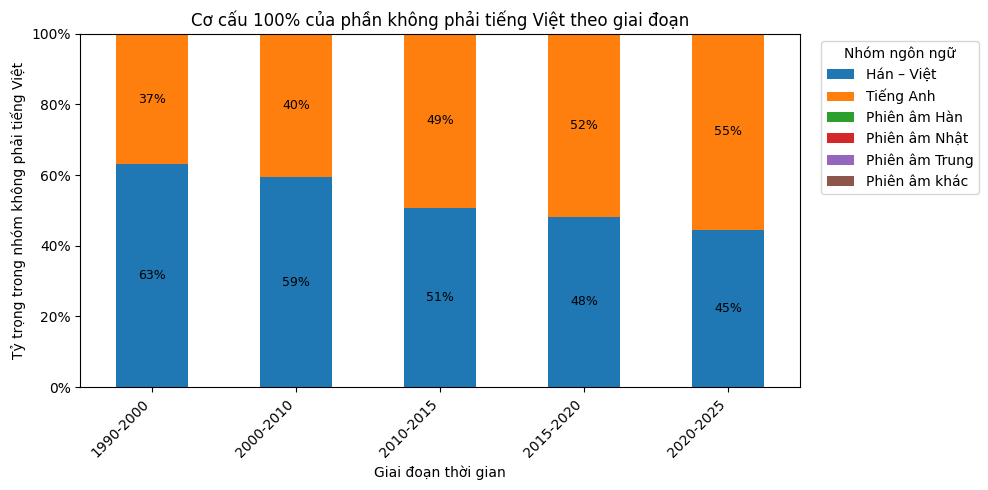

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# =========================
# 1. LOAD DATA
# =========================
PATH = "/content/drive/MyDrive/TDTU/Labeling/Calculate_Analysis/final_dataset_with_period.csv"
df = pd.read_csv(PATH, low_memory=False)

# Chỉ giữ bản ghi có giai đoạn
df = df[df["period"].notna()].copy()

# =========================
# 2. QUY ĐỔI CÁC TỶ LỆ VỀ 0-1
# Lưu ý: dataset của bạn đang lưu theo thang 0-100
# =========================
for col in ["pct_vietnamese", "pct_hanviet", "pct_english"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce") / 100.0

# =========================
# 3. TÍNH TỶ LỆ NGOẠI NGỮ THEO TỪNG NHÓM (NHẬT/HÀN/TRUNG/KHÁC)
# Dựa trên các cột num_foreign_* và total_non_punct đã có sẵn trong file của bạn
# =========================
df["pct_foreign_japanese"] = df["num_foreign_japanese"] / df["total_non_punct"]
df["pct_foreign_korean"]   = df["num_foreign_korean"]   / df["total_non_punct"]
df["pct_foreign_chinese"]  = df["num_foreign_chinese"]  / df["total_non_punct"]
df["pct_foreign_other"]    = df["num_foreign_other"]    / df["total_non_punct"]

df["pct_foreign_total"] = (
    df["pct_foreign_japanese"] +
    df["pct_foreign_korean"] +
    df["pct_foreign_chinese"] +
    df["pct_foreign_other"]
)

# =========================
# 4. CÂU HỎI 1: "PHẦN CÒN LẠI SAU KHI BỎ TIẾNG VIỆT" CHIẾM BAO NHIÊU % TRÊN TOÀN BỘ?
# Định nghĩa phần còn lại = Hán-Việt + Tiếng Anh + Ngoại ngữ
# =========================
df["pct_non_vietnamese_on_total"] = df["pct_hanviet"] + df["pct_english"] + df["pct_foreign_total"]

# =========================
# 5. CÂU HỎI 2: CHUẨN HOÁ PHẦN "KHÔNG PHẢI TIẾNG VIỆT" VỀ 100%
# Tức là: (Hán-Việt + Anh + Nhật + Hàn + Trung + Khác) = 100%
# =========================
df["pct_non_vi_total"] = (
    df["pct_hanviet"] +
    df["pct_english"] +
    df["pct_foreign_japanese"] +
    df["pct_foreign_korean"] +
    df["pct_foreign_chinese"] +
    df["pct_foreign_other"]
)

# Tránh chia cho 0 (bài hoàn toàn không có thành phần ngoài tiếng Việt)
df = df[df["pct_non_vi_total"] > 0].copy()

df["hanviet_norm"] = df["pct_hanviet"] / df["pct_non_vi_total"]
df["english_norm"] = df["pct_english"] / df["pct_non_vi_total"]
df["japan_norm"]   = df["pct_foreign_japanese"] / df["pct_non_vi_total"]
df["korea_norm"]   = df["pct_foreign_korean"]   / df["pct_non_vi_total"]
df["china_norm"]   = df["pct_foreign_chinese"]  / df["pct_non_vi_total"]
df["other_norm"]   = df["pct_foreign_other"]    / df["pct_non_vi_total"]

# =========================
# 6. SẮP XẾP GIAI ĐOẠN
# =========================
period_order = ["1990-2000", "2000-2010", "2010-2015", "2015-2020", "2020-2025"]
df["period"] = pd.Categorical(df["period"], categories=period_order, ordered=True)

# =========================
# 7. IN RA BẢNG: PHẦN CÒN LẠI CHIẾM BAO NHIÊU % TRÊN TOÀN BỘ LYRICS
# =========================
share_table = (
    df.groupby("period", observed=True)["pct_non_vietnamese_on_total"]
      .mean()
      .reindex(period_order)
      .reset_index()
)
share_table["pct_non_vietnamese_on_total"] = share_table["pct_non_vietnamese_on_total"] * 100

print("Tỷ lệ trung bình của phần không phải tiếng Việt trên toàn bộ lyrics theo giai đoạn:")
print(share_table)

# =========================
# 8. TỔNG HỢP ĐỂ VẼ BIỂU ĐỒ: CƠ CẤU 100% TRONG PHẦN KHÔNG PHẢI TIẾNG VIỆT
# =========================
agg = (
    df.groupby("period", observed=True)[
        ["hanviet_norm", "english_norm", "korea_norm", "japan_norm", "china_norm", "other_norm"]
    ]
    .mean()
    .rename(columns={
        "hanviet_norm": "Hán – Việt",
        "english_norm": "Tiếng Anh",
        "korea_norm": "Phiên âm Hàn",
        "japan_norm": "Phiên âm Nhật",
        "china_norm": "Phiên âm Trung",
        "other_norm": "Phiên âm khác"
    })
    .reindex(period_order)
)

# =========================
# 9. VẼ BIỂU ĐỒ
# =========================
ax = agg.plot(kind="bar", stacked=True, figsize=(10, 5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0, 1)

THRESHOLD = 0.05  # chỉ hiển thị nhãn nếu >=5%
for container in ax.containers:
    labels = [
        f"{v*100:.0f}%" if pd.notna(v) and v >= THRESHOLD else ""
        for v in container.datavalues
    ]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=9)

plt.title("Cơ cấu 100% của phần không phải tiếng Việt theo giai đoạn")
plt.xlabel("Giai đoạn thời gian")
plt.ylabel("Tỷ trọng trong nhóm không phải tiếng Việt")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Nhóm ngôn ngữ", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


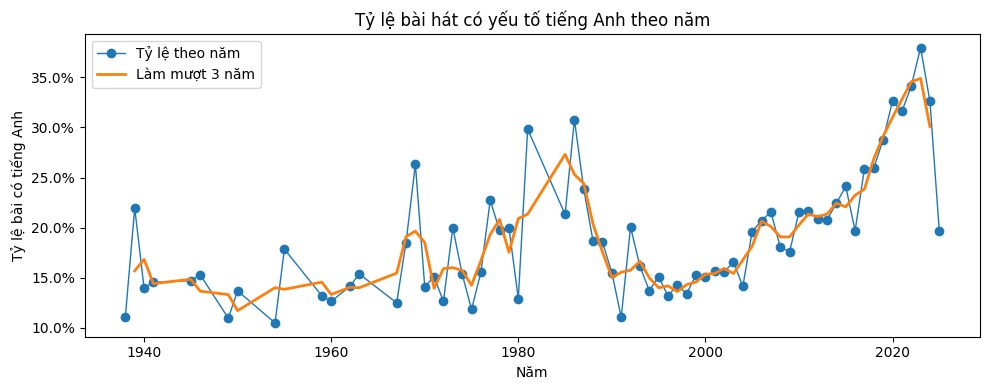

,year_num,n_records,n_english,pct_english_present,pct_roll3
37,1938,54,6,0.111111,NaN
38,1939,173,38,0.219653,0.156921
39,1940,50,7,0.140000,0.168369
40,1941,55,8,0.145455,0.144211
44,1945,2711,399,0.147178,0.148565
45,1946,98,15,0.153061,0.136665
48,1949,82,9,0.109756,0.133268
49,1950,146,20,0.136986,0.117238
53,1954,181,19,0.104972,0.140177
54,1955,168,30,0.178571,0.138540


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['year_num'].plot(kind='hist', bins=20, title='year_num')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['n_records'].plot(kind='hist', bins=20, title='n_records')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['n_english'].plot(kind='hist', bins=20, title='n_english')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='year_num', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='year_num', y='n_records', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='n_records', y='n_english', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='n_english', y='pct_english_present', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['n_records']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('n_records')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['n_english']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('n_english')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['pct_english_present']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('pct_english_present')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['pct_roll3']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('pct_roll3')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['year_num'].plot(kind='line', figsize=(8, 4), title='year_num')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['n_records'].plot(kind='line', figsize=(8, 4), title='n_records')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['n_english'].plot(kind='line', figsize=(8, 4), title='n_english')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:


PATH = "/content/drive/MyDrive/TDTU/Labeling/Calculate_Analysis/final_dataset_with_period.csv"
df = pd.read_csv(PATH, low_memory=False)

# 1) Chuẩn hoá year
df["year_num"] = pd.to_numeric(df["year"], errors="coerce")
df_year = df[df["year_num"].notna()].copy()
df_year["year_num"] = df_year["year_num"].astype(int)

# 2) Tạo biến English_present (bám cột có sẵn)
# Ưu tiên num_english vì bạn đã có
df_year["english_present"] = pd.to_numeric(df_year["num_english"], errors="coerce").fillna(0).gt(0)

# 3) Tổng hợp theo năm
by_year = df_year.groupby("year_num").agg(
    n_records=("title", "count"),
    n_english=("english_present", "sum")
).reset_index()

by_year["pct_english_present"] = by_year["n_english"] / by_year["n_records"]

# 4) Lọc năm có đủ mẫu để tránh nhiễu (tuỳ chọn)
MIN_N = 50
by_year_f = by_year[by_year["n_records"] >= MIN_N].copy()

# 5) Làm mượt (rolling mean 3 năm)
by_year_f = by_year_f.sort_values("year_num")
by_year_f["pct_roll3"] = by_year_f["pct_english_present"].rolling(3, center=True).mean()

# 6) Vẽ
plt.figure(figsize=(10,4))
plt.plot(by_year_f["year_num"], by_year_f["pct_english_present"], marker="o", linewidth=1, label="Tỷ lệ theo năm")
plt.plot(by_year_f["year_num"], by_year_f["pct_roll3"], linewidth=2, label="Làm mượt 3 năm")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel("Năm")
plt.ylabel("Tỷ lệ bài có tiếng Anh")
plt.title("Tỷ lệ bài hát có yếu tố tiếng Anh theo năm")
plt.legend()
plt.tight_layout()
plt.show()

by_year_f.head(10)


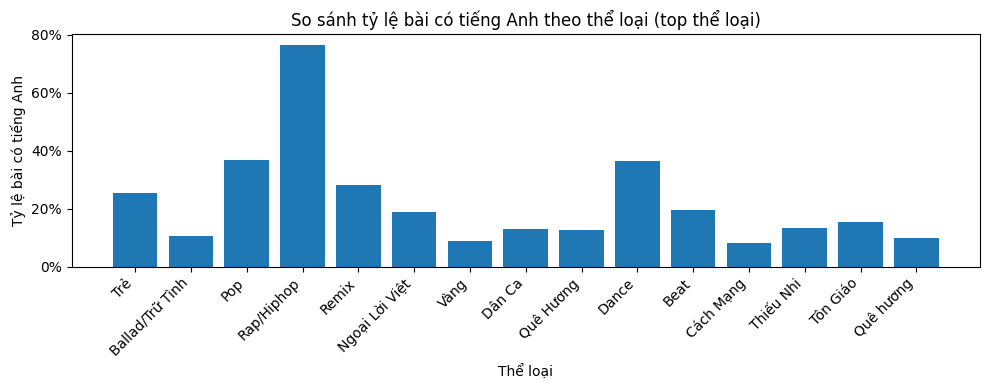

In [ ]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

df = pd.read_csv(PATH, low_memory=False)

# parse list genres (vì genres thường lưu dạng chuỗi list)
def parse_list(x):
    if pd.isna(x): return []
    if isinstance(x, list): return x
    s = str(x).strip()
    try:
        v = ast.literal_eval(s)
        return v if isinstance(v, list) else [v]
    except:
        return [t.strip() for t in s.split(",") if t.strip()]

df["genres_list"] = df["genres"].apply(parse_list)
df["num_english"] = pd.to_numeric(df["num_english"], errors="coerce").fillna(0)
df["english_present"] = df["num_english"].gt(0)

g = df.explode("genres_list").rename(columns={"genres_list":"genre"})
g = g[g["genre"].notna() & (g["genre"].astype(str).str.strip() != "")].copy()

# top genres theo số lượng
genre_stat = g.groupby("genre").agg(
    n_records=("title","count"),
    pct_english_present=("english_present","mean")
).reset_index()

genre_stat = genre_stat[genre_stat["n_records"] >= 200].sort_values("n_records", ascending=False).head(15)

plt.figure(figsize=(10,4))
plt.bar(genre_stat["genre"].astype(str), genre_stat["pct_english_present"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=45, ha="right")
plt.xlabel("Thể loại")
plt.ylabel("Tỷ lệ bài có tiếng Anh")
plt.title("So sánh tỷ lệ bài có tiếng Anh theo thể loại (top thể loại)")
plt.tight_layout()
plt.show()


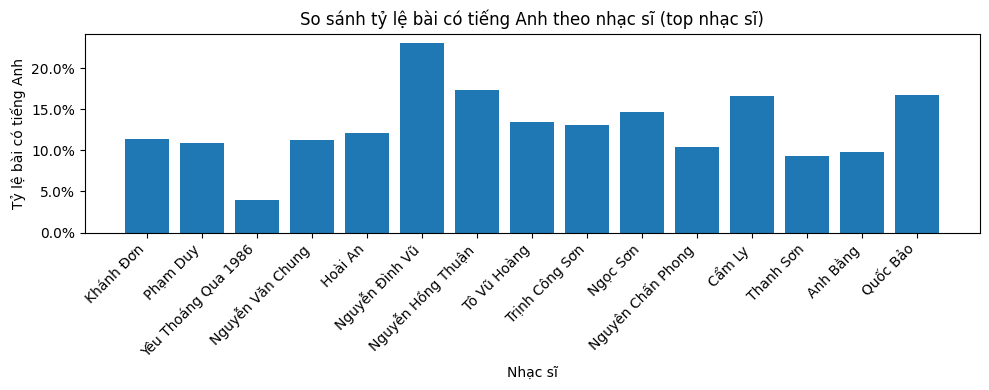

In [ ]:
df["composers_list"] = df["composers"].apply(parse_list)
c = df.explode("composers_list").rename(columns={"composers_list":"composer"})
c = c[c["composer"].notna() & (c["composer"].astype(str).str.strip() != "")].copy()

composer_stat = c.groupby("composer").agg(
    n_records=("title","count"),
    pct_english_present=("english_present","mean")
).reset_index()

composer_stat = composer_stat[composer_stat["n_records"] >= 200].sort_values("n_records", ascending=False).head(15)

plt.figure(figsize=(10,4))
plt.bar(composer_stat["composer"].astype(str), composer_stat["pct_english_present"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=45, ha="right")
plt.xlabel("Nhạc sĩ")
plt.ylabel("Tỷ lệ bài có tiếng Anh")
plt.title("So sánh tỷ lệ bài có tiếng Anh theo nhạc sĩ (top nhạc sĩ)")
plt.tight_layout()
plt.show()


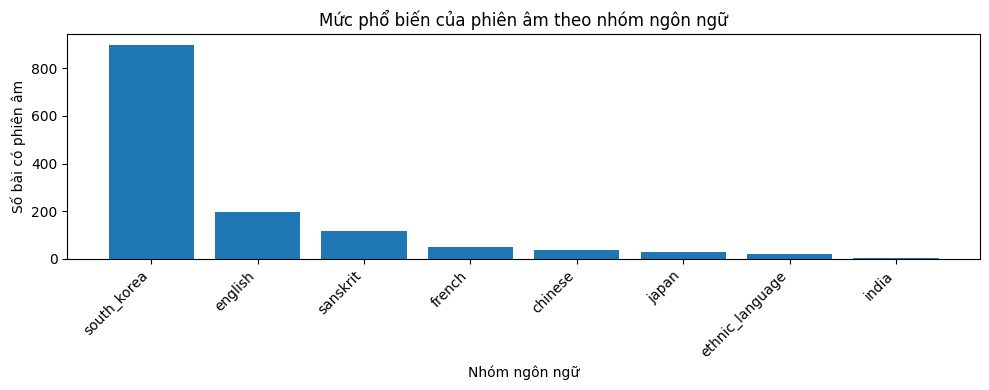

/tmp/ipython-input-3343755398.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_period = present_df[top_cols].groupby(df["period"]).mean().reindex(period_order)


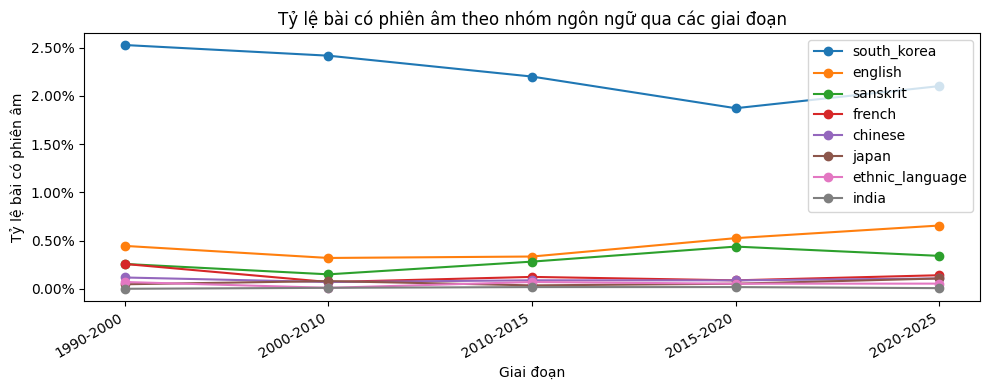

,language_group,n_songs
0,phien_am_south_korea,896
1,phien_am_english,198
2,phien_am_sanskrit,118
3,phien_am_french,51
4,phien_am_chinese,38
5,phien_am_japan,31
6,phien_am_ethnic_language,19
7,phien_am_india,4
8,phien_am_hebrew,4
9,phien_am_spanish,3


,period,phien_am_south_korea,phien_am_english,phien_am_sanskrit,phien_am_french,phien_am_chinese,phien_am_japan,phien_am_ethnic_language,phien_am_india
0,1990-2000,0.025287,0.004449,0.002576,0.002576,0.001171,0.000468,0.000702,0.000000
1,2000-2010,0.024181,0.003197,0.001499,0.000699,0.000699,0.000799,0.000100,0.000100
2,2010-2015,0.022015,0.003346,0.002818,0.001233,0.000881,0.000352,0.000704,0.000176
3,2015-2020,0.018732,0.005252,0.004377,0.000875,0.000875,0.000525,0.000525,0.000175
4,2020-2025,0.021024,0.006562,0.003415,0.001406,0.001071,0.001071,0.000536,0.000067


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

PATH = "/content/drive/MyDrive/TDTU/Labeling/Calculate_Analysis/final_dataset_with_period.csv"
df = pd.read_csv(PATH, low_memory=False)

df = df[df["period"].notna()].copy()

period_order = ["1990-2000","2000-2010","2010-2015","2015-2020","2020-2025"]
df["period"] = pd.Categorical(df["period"], categories=period_order, ordered=True)

# Lấy các cột phiên âm theo ngôn ngữ
ph_cols = [c for c in df.columns if c.startswith("phien_am_")]

# Nếu muốn loại cột phiên âm tiếng Việt (nếu có) để tập trung vào nhóm nước ngoài
if "phien_am_vietnamese" in ph_cols:
    ph_cols.remove("phien_am_vietnamese")

def present_series(s):
    return s.fillna("").astype(str).str.strip().ne("")

present_df = pd.DataFrame({c: present_series(df[c]) for c in ph_cols})

# Tổng hợp toàn bộ theo ngôn ngữ
counts = present_df.sum().sort_values(ascending=False)

TOP_K = 8
top_cols = counts.head(TOP_K).index.tolist()

# Hình 4.10: số bài có phiên âm theo ngôn ngữ (top nhóm)
plt.figure(figsize=(10,4))
plt.bar([c.replace("phien_am_", "") for c in top_cols], counts[top_cols].values)
plt.xlabel("Nhóm ngôn ngữ")
plt.ylabel("Số bài có phiên âm")
plt.title("Mức phổ biến của phiên âm theo nhóm ngôn ngữ")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Tổng hợp theo giai đoạn: tỷ lệ bài có phiên âm
by_period = present_df[top_cols].groupby(df["period"]).mean().reindex(period_order)

# Hình 4.11: xu hướng theo giai đoạn
plt.figure(figsize=(10,4))
for c in top_cols:
    plt.plot(
        by_period.index.astype(str),
        by_period[c].values,
        marker="o",
        linewidth=1.5,
        label=c.replace("phien_am_", "")
    )

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel("Giai đoạn")
plt.ylabel("Tỷ lệ bài có phiên âm")
plt.title("Tỷ lệ bài có phiên âm theo nhóm ngôn ngữ qua các giai đoạn")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Bảng kiểm tra nhanh
display(counts.head(15).reset_index().rename(columns={"index":"language_group", 0:"n_songs"}))
display(by_period.reset_index())
